In [1]:
%matplotlib inline
from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns  #seaborn makes matplotlib look a lot better

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
dbPath = "Resources/hawaii.sqlite"

# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{dbPath}")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Is everything working? If it is we'll get a result here
engine.execute("SELECT * FROM measurement LIMIT 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Working this out was a bitch... I forgot about tuples and other python oddities.
# cribbed from https://docs.sqlalchemy.org/en/13/orm/tutorial.html#returning-lists-and-scalars
# and https://stackoverflow.com/questions/19233775/how-to-remove-parenthesis-from-output-python
# I'm sure there's a more direct way, but I couldn't figure it out
lastDate = session.query(Measure.date).order_by(Measure.date.desc())

# This extracts the date from the tuple
x = lastDate.first()
lastMeasureDate = x[0]

#https://stackabuse.com/converting-strings-to-datetime-in-python/
dateTimeOjb = dt.datetime.strptime(lastMeasureDate,"%Y-%m-%d")
yearOldDate = dateTimeOjb.date() - dt.timedelta(days=365)
# Personal sanity check
print(f'Tuple hell {x}')
print(f'Last Measurement taken on: {lastMeasureDate}')
print(f'Last measurement minus 1 year taken on: {yearOldDate}')




Tuple hell ('2017-08-23',)
Last Measurement taken on: 2017-08-23
Last measurement minus 1 year taken on: 2016-08-23


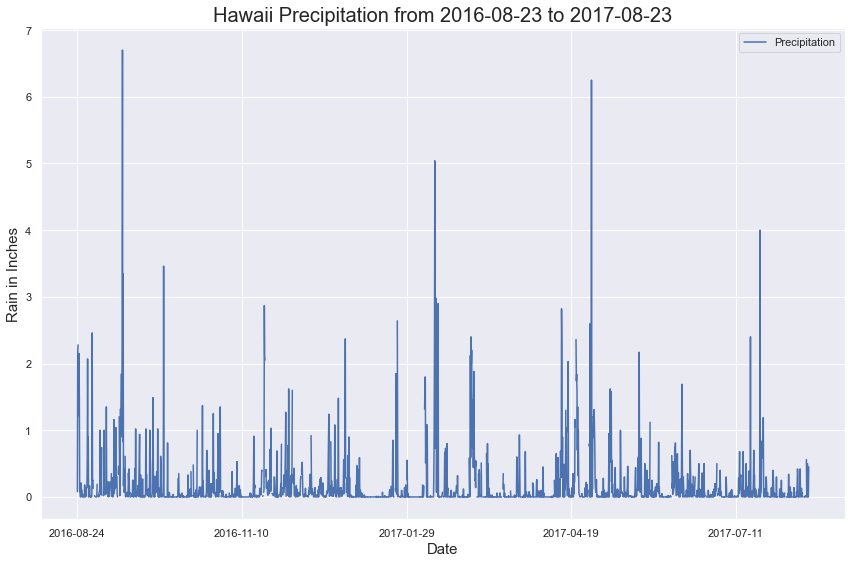

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 2017-08-23
# Calculate the date one year from the last date in data set. (see above)

# Sanity check
# print(yearOldDate)
# print(lastMeasureDate)

# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measure.date, Measure.prcp).filter(Measure.date > yearOldDate).order_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rainDF = pd.DataFrame(rain)
# display(rainDF)
# display(rainDF.set_index('date'))

# Sort the dataframe by date
rainDF.sort_values(by=['date'], inplace = True)
sns.set()
# Use Pandas Plotting with Matplotlib to plot the data
rainDF.plot('date', 'prcp', figsize = (12,8))
plt.xlabel("Date", size = 15)
plt.ylabel("Rain in Inches", size = 15)
# Title date range is generated dynamically using the DT variables calculated above
# If we ever change the date range they update automatically.
plt.title(f'Hawaii Precipitation from {yearOldDate} to {lastMeasureDate}', size = 20)
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainDF.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(Measure).group_by(Measure.station).count()
print(f'There are {locations} stations.')


There are 9 stations.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
observationCount = session.query(Measure.station, func.count(Measure.tobs)).group_by(Measure.station).\
               order_by(func.count(Measure.tobs).desc()).all()
#print(observationCount)
# List the stations and the counts in descending order.
busiest = observationCount[0]
print(f'The most observations were taken by station {busiest[0]} with {busiest[1]} readings.')
print(f'\nThese are the stations and their reading counts')
print(f'-----------------------------------------------')
for station, count in observationCount:
    print(f'{station} had {count} readings.')

The most observations were taken by station USC00519281 with 2772 readings.

These are the stations and their reading counts
-----------------------------------------------
USC00519281 had 2772 readings.
USC00519397 had 2724 readings.
USC00513117 had 2709 readings.
USC00519523 had 2669 readings.
USC00516128 had 2612 readings.
USC00514830 had 2202 readings.
USC00511918 had 1979 readings.
USC00517948 had 1372 readings.
USC00518838 had 511 readings.


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

y = session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
    filter(Measure.station == busiest[0]).all()
# print(y[0][0])
# print(y[0][1])
# print(y[0][2])
print(f'The low temperature during the sample period was {y[0][0]}F\
, the high was {y[0][2]}F and the average was {"{:.2f}".format(y[0][1])}F.')

The low temperature during the sample period was 54.0F, the high was 85.0F and the average was 71.66F.


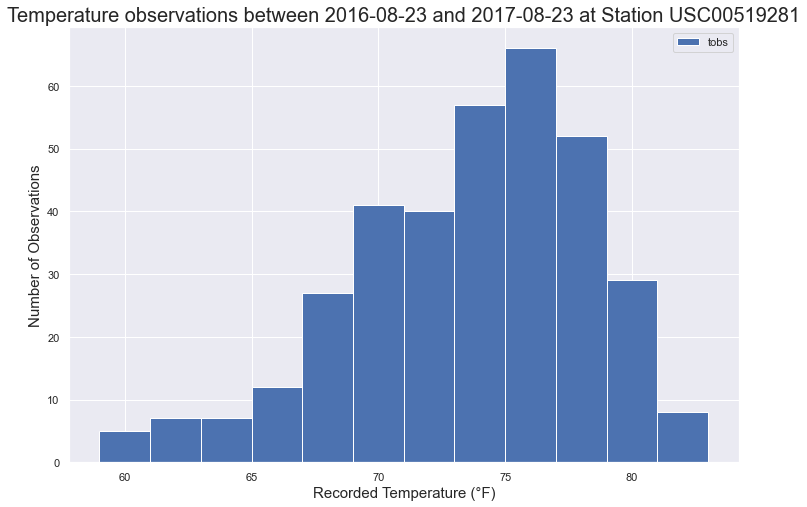

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measure.station, Measure.date, Measure.tobs).\
    filter(Measure.station == busiest[0]).\
    filter(Measure.date > yearOldDate).\
    order_by(Measure.date).all()
tempDF=pd.DataFrame(temperature)
tempDF.plot.hist(['tobs'],12,figsize = (12,8) )

plt.xlabel("Recorded Temperature (°F)", size ='15')
plt.ylabel("Number of Observations", size ='15')
plt.title(f'Temperature observations between {yearOldDate} and {lastMeasureDate} at Station {busiest[0]}', size ="20")
plt.show()

# Close session

In [17]:
# Close Session
session.close()